In [1]:
# basic python packages
import numpy as np
import pandas as pd
import os
import sys 

# plotting
from matplotlib import pyplot as plt 
import seaborn as sns 
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# singlecell packages
import scanpy as sc
import anndata
import scrublet
import harmonypy as hm

# other single cell packages
import muon as mu # multi-modal anndatas
import celltypist # automated label predictions
import scirpy # immune cell repertoire analysis
import cellanova as cnova
import gseapy as gp

#sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load BigSur
bigsur_dir = '/home/groups/singlecell/smorabito/bin/BigSur/'
sys.path.append(bigsur_dir) 

from BigSur.feature_selection import mcfano_feature_selection as mcfano

In [3]:
# helper func
def append_percent_expressed(adata, marker_genes_df, group_key, expression_thresh):
    """
    Append percentage of cells expressing each gene in the cluster of interest
    (pct_in_group) and in all other clusters (pct_out_group) to the marker gene DataFrame.

    Parameters:
    - adata: AnnData object.
    - marker_genes_df: DataFrame of marker genes generated by sc.tl.rank_genes_groups.
    - group_key: Column in adata.obs containing cluster annotations (e.g., 'leiden').

    Returns:
    - Updated marker gene DataFrame with pct_in_group and pct_out_group columns.
    """
    # Binary matrix indicating whether each gene is expressed in each cell
    binary_matrix = adata.X > expression_thresh  # Adjust if data is log-transformed or sparse
    
    # Initialize new columns
    pct_in_group_list = []
    pct_out_group_list = []

    # Iterate over each cluster in the marker gene DataFrame
    unique_clusters = marker_genes_df["group"].unique()
    for cluster in unique_clusters:
        print(cluster)
        # Create a mask for the cluster of interest
        cluster_mask = adata.obs[group_key] == cluster

        # Calculate percentages
        pct_in_group = np.asarray(binary_matrix[cluster_mask, :].mean(axis=0)).flatten() * 100
        pct_out_group = np.asarray(binary_matrix[~cluster_mask, :].mean(axis=0)).flatten() * 100

        # Map percentages back to marker genes
        for gene in marker_genes_df[marker_genes_df["group"] == cluster]["names"]:
            gene_idx = adata.var_names.get_loc(gene)
            pct_in_group_list.append(pct_in_group[gene_idx])
            pct_out_group_list.append(pct_out_group[gene_idx])

    # Add the calculated percentages to the DataFrame
    marker_genes_df["pct_in_group"] = pct_in_group_list
    marker_genes_df["pct_out_group"] = pct_out_group_list

    return marker_genes_df



In [4]:
# set the project directory 
os.chdir('/home/groups/singlecell/smorabito/analysis/SERPENTINE/clustering/testing')
data_dir = 'data/'
fig_dir = 'figures/'

In [5]:
# load the SERPENTINE dataset 
adata_met = sc.read_h5ad(
    '/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SERPENTINE_PCA_27-11-24_annotated.h5ad'
)

In [6]:
# load the Chen et al dataset
adata_pri = sc.read_h5ad(
    '/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/Chen2024_Tumor_processed_201124.h5ad'
)

## align the meta-data for the two 

Will need to do this more carefully later but just to test the integration I will only use the most necessary columns

* Patient
* Timepoint (Need to standardize these?) OMG I didn't add this yet, what is wrong w/ me
* MSS / MSI status

In [7]:
# rename columns in the primary tumor dataset:
new_cols = {
    'Ident' : 'Replicate',
    'MajorCellType': 'cell_type',
    'SubCellType' : 'orig_annotation',
    'Treatment' : 'Timepoint'
}

adata_pri.obs = adata_pri.obs.rename(columns=new_cols)


In [8]:
# fix the timepoint in the primary tumor dataset
adata_pri.obs.Timepoint.replace(
    {'I': 1, 'II':2, 'III':3, 'IV':4},
    inplace=True
)

In [9]:
# fix the Tissue name in the SERPENTINE dataset 
adata_met.obs.Tissue.value_counts()

Tissue
Liver met                                 161299
Lung met                                   71840
Peritoneum (right iliac fossa)             15291
Lymphnode (iliac)                          14344
Lymphnode (right axilary)                  13041
Peritoneal implant (right iliac fossa)      6828
Subcutaneous tissue �nodul�                 4757
Implant (nodul) pre-sacro                   3474
Lymphnode (hepatic iliar)                   1409
Name: count, dtype: int64

In [10]:
# fix the timepoint in the primary tumor dataset
adata_met.obs.Tissue.replace(
    {
        'Lymphnode (right axilary)': 'Lymph node',
        'Lymphnode (iliac)': 'Lymph node',
        'Lymphnode (hepatic iliar)': 'Lymph node',
        'Peritoneum (right iliac fossa)': 'Peritoneum',
        'Peritoneal implant (right iliac fossa)': 'Peritoneum'
    },
    inplace=True
)

In [11]:
# add dataset columns:
adata_met.obs['dataset'] = 'SERPENTINE'
adata_pri.obs['dataset'] = 'Chen2024'

In [12]:
# common columns:
columns_keep = list(set(adata_pri.obs.columns.to_list()) & set(adata_met.obs.columns.to_list()))
columns_keep = adata_met.obs.columns[adata_met.obs.columns.isin(columns_keep)].to_list()

In [13]:
# subset metadata by common columns:
adata_pri.obs = adata_pri.obs[columns_keep]
adata_met.obs = adata_met.obs[columns_keep]

In [14]:

# add the original annotations (from Gerard for SERPENTINE, and from Chen et al
adata_met.obs['bc'] = [x.split('-')[0] for x in adata_met.obs.index.to_list()]

# load the annotations
anno_df = pd.read_table('/home/groups/singlecell/smorabito/analysis/SERPENTINE/data/SP_annotations.csv', sep=',')
anno_df = anno_df.rename({'Unnamed: 0': 'barcode'}, axis=1)
anno_df['bc'] = [x.split('_')[-1] for x in anno_df.barcode.to_list()]
anno_df['bc_sample'] = anno_df['sample'].astype(str) + '-' + anno_df.bc.astype(str)

adata_met.obs['bc_sample'] = adata_met.obs.Replicate.astype(str) + '-' + adata_met.obs.bc.astype(str)
temp = adata_met.obs.merge(anno_df, how='left', on = 'bc_sample')
adata_met.obs['orig_annotation'] = temp['Annotation_2.0'].to_list()


In [15]:
# subset by celltype of interest 
cur_name = 'Tcells'

adata_pri = adata_pri[adata_pri.obs.cell_type.isin(['T', 'ILC'])].copy()
adata_met = adata_met[adata_met.obs.cell_type.isin(['T cells', 'NK cells'])].copy()

In [16]:
# fix the gene ids before merging
adata_met.var.gene_ids = adata_met.var.index.to_list()

In [17]:
# merge
adata = adata_pri.concatenate(adata_met) 
adata.shape

(298073, 36017)

In [18]:
adata = adata[adata.obs.pct_counts_mt <= 5].copy()
adata.shape

(280125, 36017)

## Run feature selection

Running the Feature Selection (BigSur) separately by Tissue. Alternatively this could be done by replicate?

* Primary Tumor
* Liver met
* Lung met
* Lymph node
* Other (includes the peritoneum & subcutaneous nodules, putting them together since they don't make up very much of the results. Maybe don't even include these ones?)

We will run enrichment analysis (`enrichR` via `gseapy`) to identify pathways which may be enriched in genes that are specific to a particular tissue.


In [ ]:
tissues = ['Tumor', 'Liver met', 'Lung met', 'Lymph node']
tissue_vars = {}

for cur_tissue in tissues:
    print(cur_tissue)
    cur_adata = adata[adata.obs.Tissue == cur_tissue].copy()

    sc.pp.filter_genes(cur_adata, min_cells=3)
    mcfano(cur_adata, layer='counts')

    tissue_vars[cur_tissue] = cur_adata.var.copy()
    

Tumor
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.


In [ ]:
# calculate average stats:

# what genes are in all tissues:
genes_keep = list(set.intersection(*map(set, [x.index.to_list() for key, x in tissue_vars.items()])))
tissue_vars_common = {tissue: var.loc[genes_keep][['p_value', 'mc_Fano']] for tissue, var in tissue_vars.items()}

dfs = [x for x in tissue_vars_common.values()]
combined = pd.concat(dfs, keys=tissue_vars_common.keys())  # MultiIndex to distinguish sources

# calculate averages
avg_var = combined.groupby(level=1).mean()
avg_var.head()

# FDR correction
reject, pvals_corrected, _, _ = multipletests(avg_var['p_value'], alpha=0.05, method='fdr_bh')
avg_var['FDR_adj_pvalue'] = pvals_corrected

# quantile & p-val 
mc_cutoff = np.quantile(avg_var['mc_Fano'], q=0.9)
p_cutoff = 0.05

variable_features = (avg_var.mc_Fano >= mc_cutoff) & (avg_var.FDR_adj_pvalue <= p_cutoff)
avg_var['highly_variable'] = variable_features

# finally add this info to our adata.var 
var_genes = avg_var[avg_var.highly_variable].index.to_list()
adata.var['highly_variable'] = adata.var.index.isin(var_genes)


In [ ]:
# list of variable genes for each group:
var_genes = {
    key: x[x.highly_variable].gene_ids.to_list() for key, x in tissue_vars.items()
}

common_genes = set.intersection(*map(set, var_genes.values()))
len(common_genes)

unique_genes = {
    tissue: set(genes) - set.union(*(set(g) for t, g in var_genes.items() if t != tissue))
                for tissue, genes in var_genes.items()
}

#-------------------------------------------------#
# enrichment 
#-------------------------------------------------#

dbs = ['GO_Biological_Process_2021']
df_list = []

for cur_tissue in unique_genes.keys():
    print(cur_tissue)
    cur_genes = list(unique_genes[cur_tissue])
    cur_enr_res = gp.enrichr(
        gene_list=cur_genes, 
        organism='Human', 
        gene_sets=dbs, 
        cutoff = 0.5
    )
    cur_df = cur_enr_res.results.copy()

    # how many genes?
    cur_df['n_genes'] = [len(x.split(';')) for x in cur_df.Genes.to_list()]
    cur_df['tissue'] = cur_tissue

    # remove entries with too few genes:
    cur_df = cur_df[cur_df.n_genes > 2] 

    # sort by Combined.Score
    cur_df = cur_df.sort_values(by="Combined Score", ascending=False)    
    
    df_list.append(cur_df)
    
enrichr_df = pd.concat(df_list)

# save the table
enrichr_df.to_csv(
    "{}variable_genes_enrichR.csv".format(data_dir),
    index=False
)


In [ ]:
# list of variable genes for each group:
var_genes = {
    key: x[x.highly_variable].gene_ids.to_list() for key, x in tissue_vars.items()
}

# get a list of the genes which are variable in each tissue but not overall
unique_genes = {
    tissue: set(genes) - set(adata.var[adata.var.highly_variable].index.to_list()) for tissue, genes in var_genes.items()
}

#-------------------------------------------------#
# enrichment 
#-------------------------------------------------#

dbs = ['GO_Biological_Process_2021']
df_list = []

for cur_tissue in unique_genes.keys():
    print(cur_tissue)
    cur_genes = list(unique_genes[cur_tissue])
    cur_enr_res = gp.enrichr(
        gene_list=cur_genes, 
        organism='Human', 
        gene_sets=dbs, 
        cutoff = 0.5
    )
    cur_df = cur_enr_res.results.copy()

    # how many genes?
    cur_df['n_genes'] = [len(x.split(';')) for x in cur_df.Genes.to_list()]
    cur_df['tissue'] = cur_tissue

    # remove entries with too few genes:
    cur_df = cur_df[cur_df.n_genes > 2] 

    # sort by Combined.Score
    cur_df = cur_df.sort_values(by="Combined Score", ascending=False)    
    
    df_list.append(cur_df)
    
enrichr_df = pd.concat(df_list)

# save the table
enrichr_df.to_csv(
    "{}variable_genes_missing_enrichR.csv".format(data_dir),
    index=False
)


In [ ]:
# save the unprocessed object
adata.write_h5ad('{}merged_{}_unprocessed.h5ad'.format(data_dir, cur_name))


## Integration w/ CellANOVA

Should we use one pool of controls, or use a separate pool of controls for each tissue? Another option, we can use one pool for our data vs the other dataset.


Also want to test this pipeline just on the Liver mets!!



I should try to run it using their pre-processing (but I want to use my own HVGs from BigSur)


In [82]:
? cnova.model.preprocess_data

Signature:
 cnova.model.preprocess_data(
    adata,
    integrate_key,
    n_hvgs=3000,
    hvg_only=True,
    copy_raw=False,
    copy_lognorm=True,
)
Docstring:
Perform CellANOVA preprocessing: library size normalization + log1p + hvg selection + standardization 

Parameters
----------
adata : anndata object
    Raw data, containing gene expression counts.
integrate_key : str
    Key indicating smallest batch unit. Should be a column name of adata.obs.
n_hvgs : int, optional
    Number of highly variable genes.
hvg_only : boolean, optional
    Whether or not return only highly variable genes or all genes.
copy_raw : boolean, optional
    Whether or not save a copy of raw counts.

Returns
----------
adata: anndata object
    Data after preprocessing, which can be passed to cell state estimation.
File:      ~/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/model.py
Type:      function


In [ ]:
# reset the X to the log-normalized counts
adata.X = adata.layers['counts'].copy()

In [ ]:
# remove genes with very few counts:
sc.pp.filter_genes(adata, min_cells=3)
adata.shape

In [ ]:
# normalize
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
# subset the variable features (because dumb reasons related to running CellANOVA)
# in the end we will have to move back all the CellANOVA embeddings to 
# another adata which has all the stuff
adata = adata[:,adata.var.highly_variable].copy()

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
adata.layers['scale'] = adata.X.copy()

In [ ]:
sc.tl.pca(adata)

In [ ]:
# define the pool of controls for CellANOVA (Baseline timepoint)
# should we have a spearate pool for each Tissue?
control_dict = {
    'pool1': list(set(adata[adata.obs['Timepoint']==1,].obs['Replicate'])),
}

In [ ]:
# CellANOVA Step 1: Calculate "Main Effects"
adata = cnova.model.calc_ME(adata, integrate_key='Replicate')


In [36]:
# CellANOVA Step 2: Calculate Batch Effects (BE)
adata = cnova.model.calc_BE(
    adata,
    integrate_key = 'Replicate',
    control_dict = control_dict
)

In [37]:
# CellANOVA Step 3: Calculate Treatment Effect (TE)
adata = cnova.model.calc_TE(
    adata, 
    integrate_key='Replicate'
)

## Clustering

In [41]:
adata.layers['denoised'].shape

(280125, 1408)

In [42]:
adata.obsm

AxisArrays with keys: AIFI_L1, AIFI_L2, AIFI_L3, Immune_All_High, Immune_All_Low, X_pca, X_umap, Cmat

In [44]:
# this is from the CellANOVA tutorial
integrated = anndata.AnnData(adata.layers['denoised'], dtype=np.float32)
integrated.obs = adata.obs.copy()
integrated.var_names = adata.var_names

In [45]:
# neighbors
#
# Q: Do I really run this on the denoised expression matrix, or does this run PCA again?
# Should check the paper I think. Also, in the above step should I include more genes or just HVGs?
sc.pp.neighbors(
    integrated,
    n_neighbors=20, n_pcs=30, metric='cosine'
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [46]:
sc.tl.umap(integrated, min_dist=0.35)

In [48]:

# clustering
res_list = [1]
for res in res_list:
    print(res)
    sc.tl.leiden(integrated, resolution=res)
    integrated.obs["leiden_{}".format(str(res))] = integrated.obs.leiden.to_list()



1


IOStream.flush timed out
IOStream.flush timed out


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


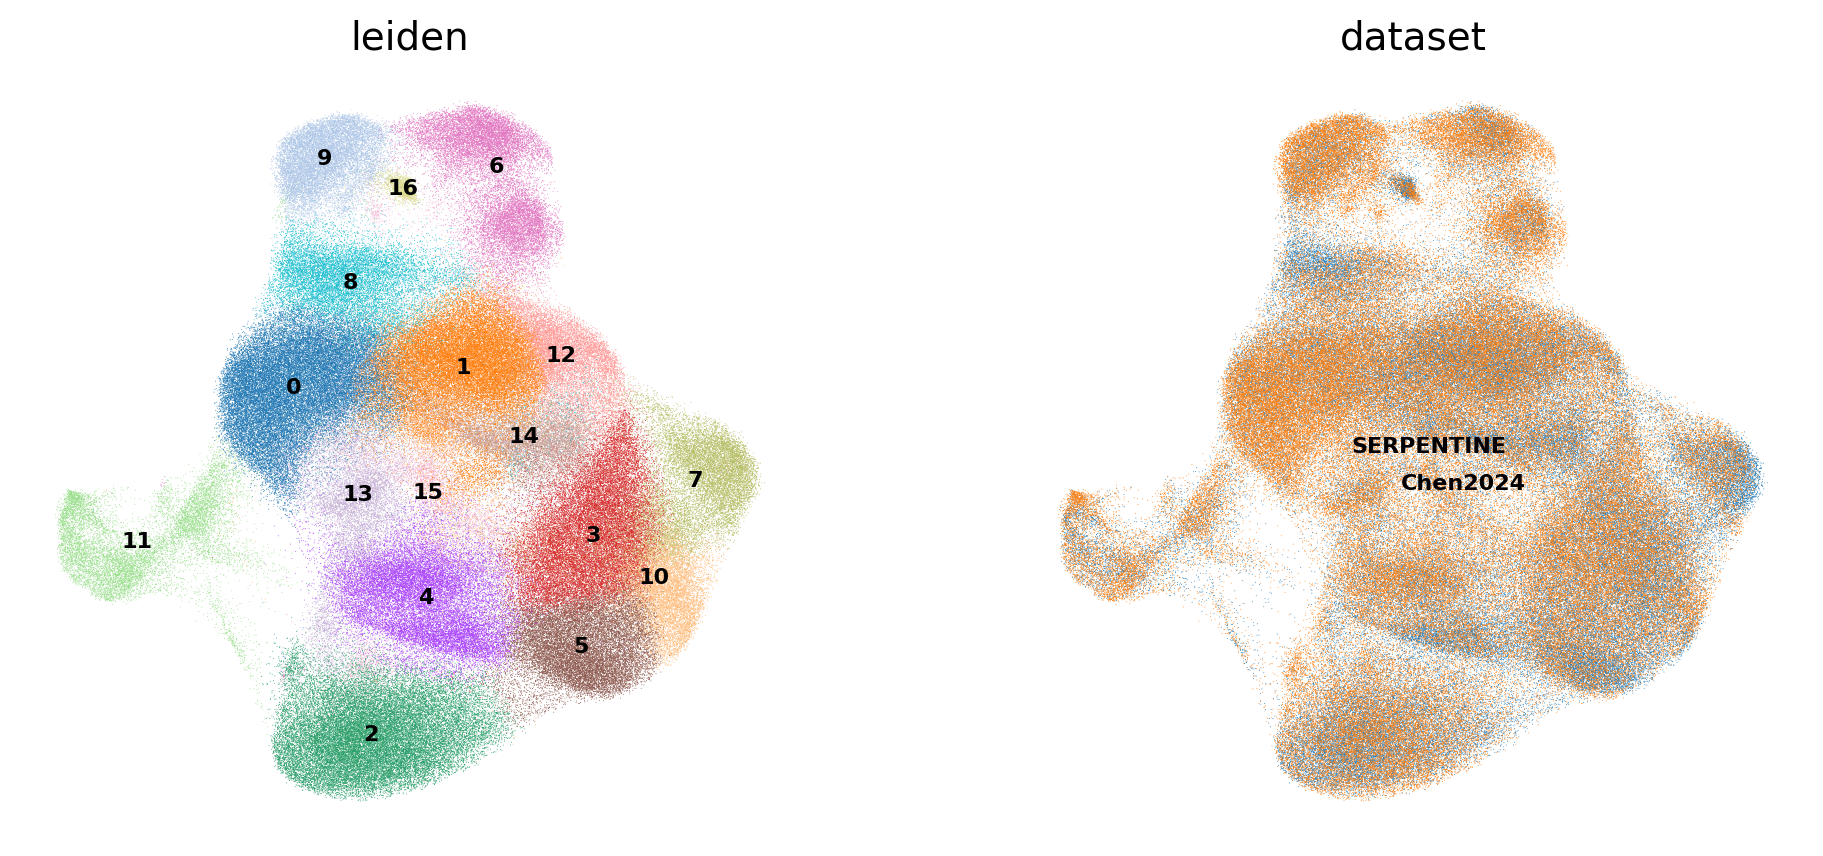

In [55]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    integrated,
    color = ['leiden', 'dataset'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    ncols=2
)

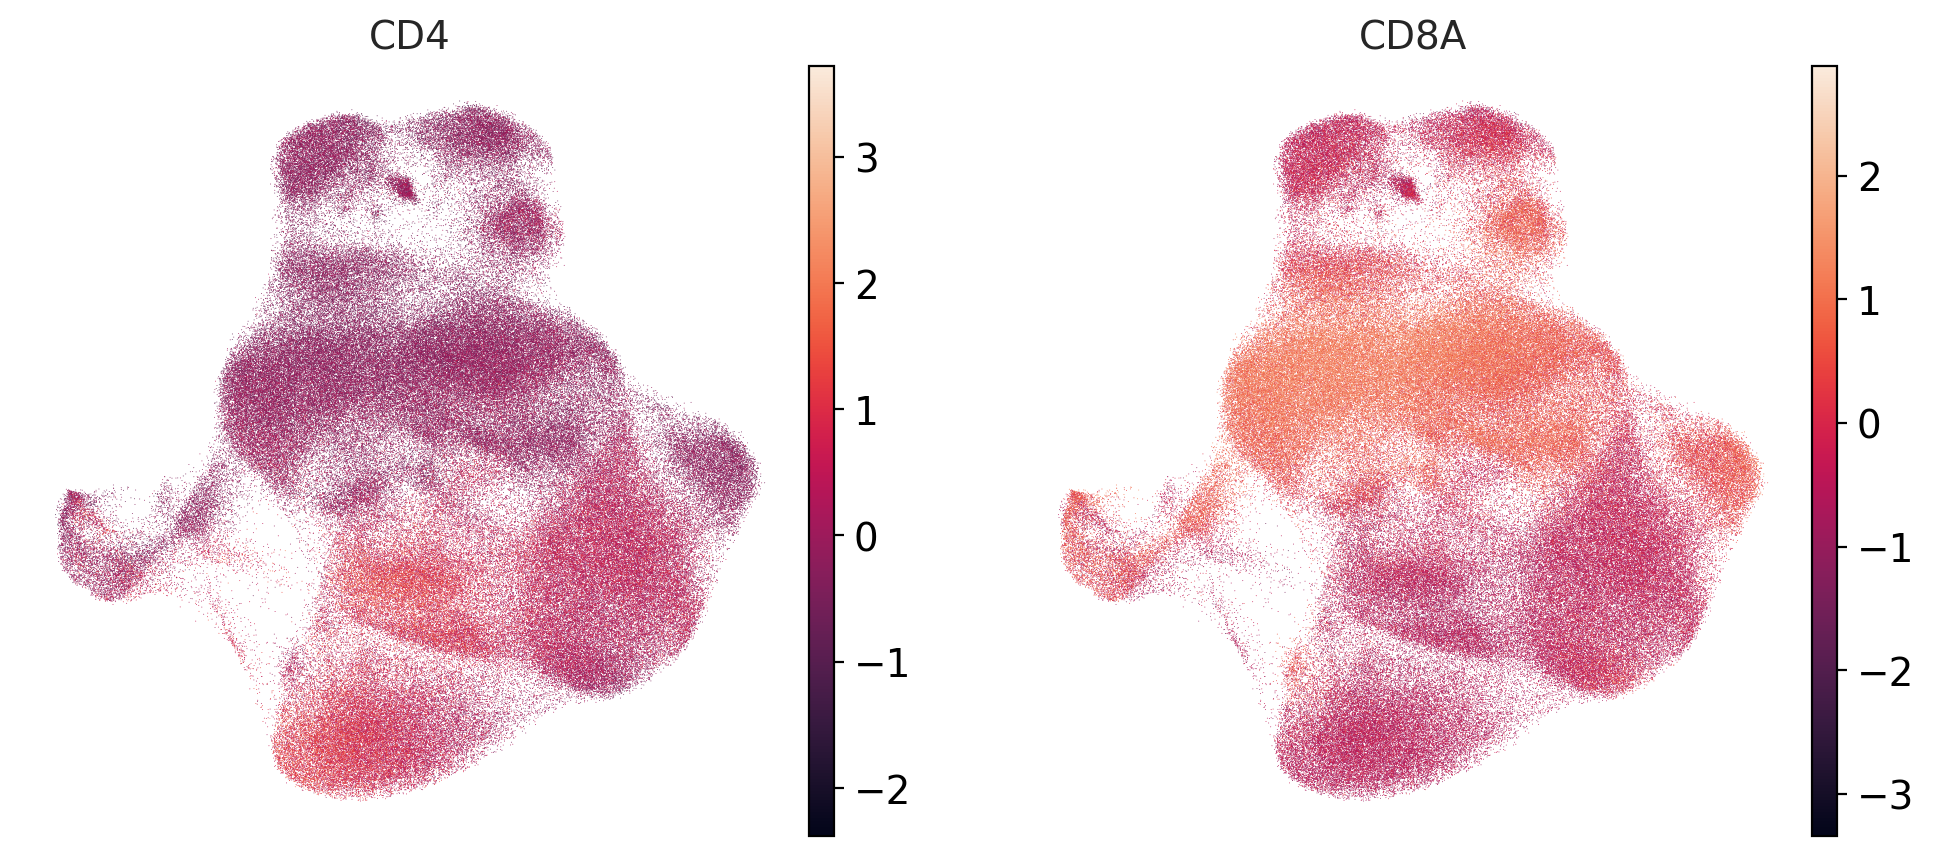

In [75]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,5), facecolor='white')

sc.pl.umap(
    integrated,
    color = ['CD4', 'CD8A'],
    legend_loc='on data', 
    legend_fontsize=8, 
    frameon = False,
    ncols=2
)

/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


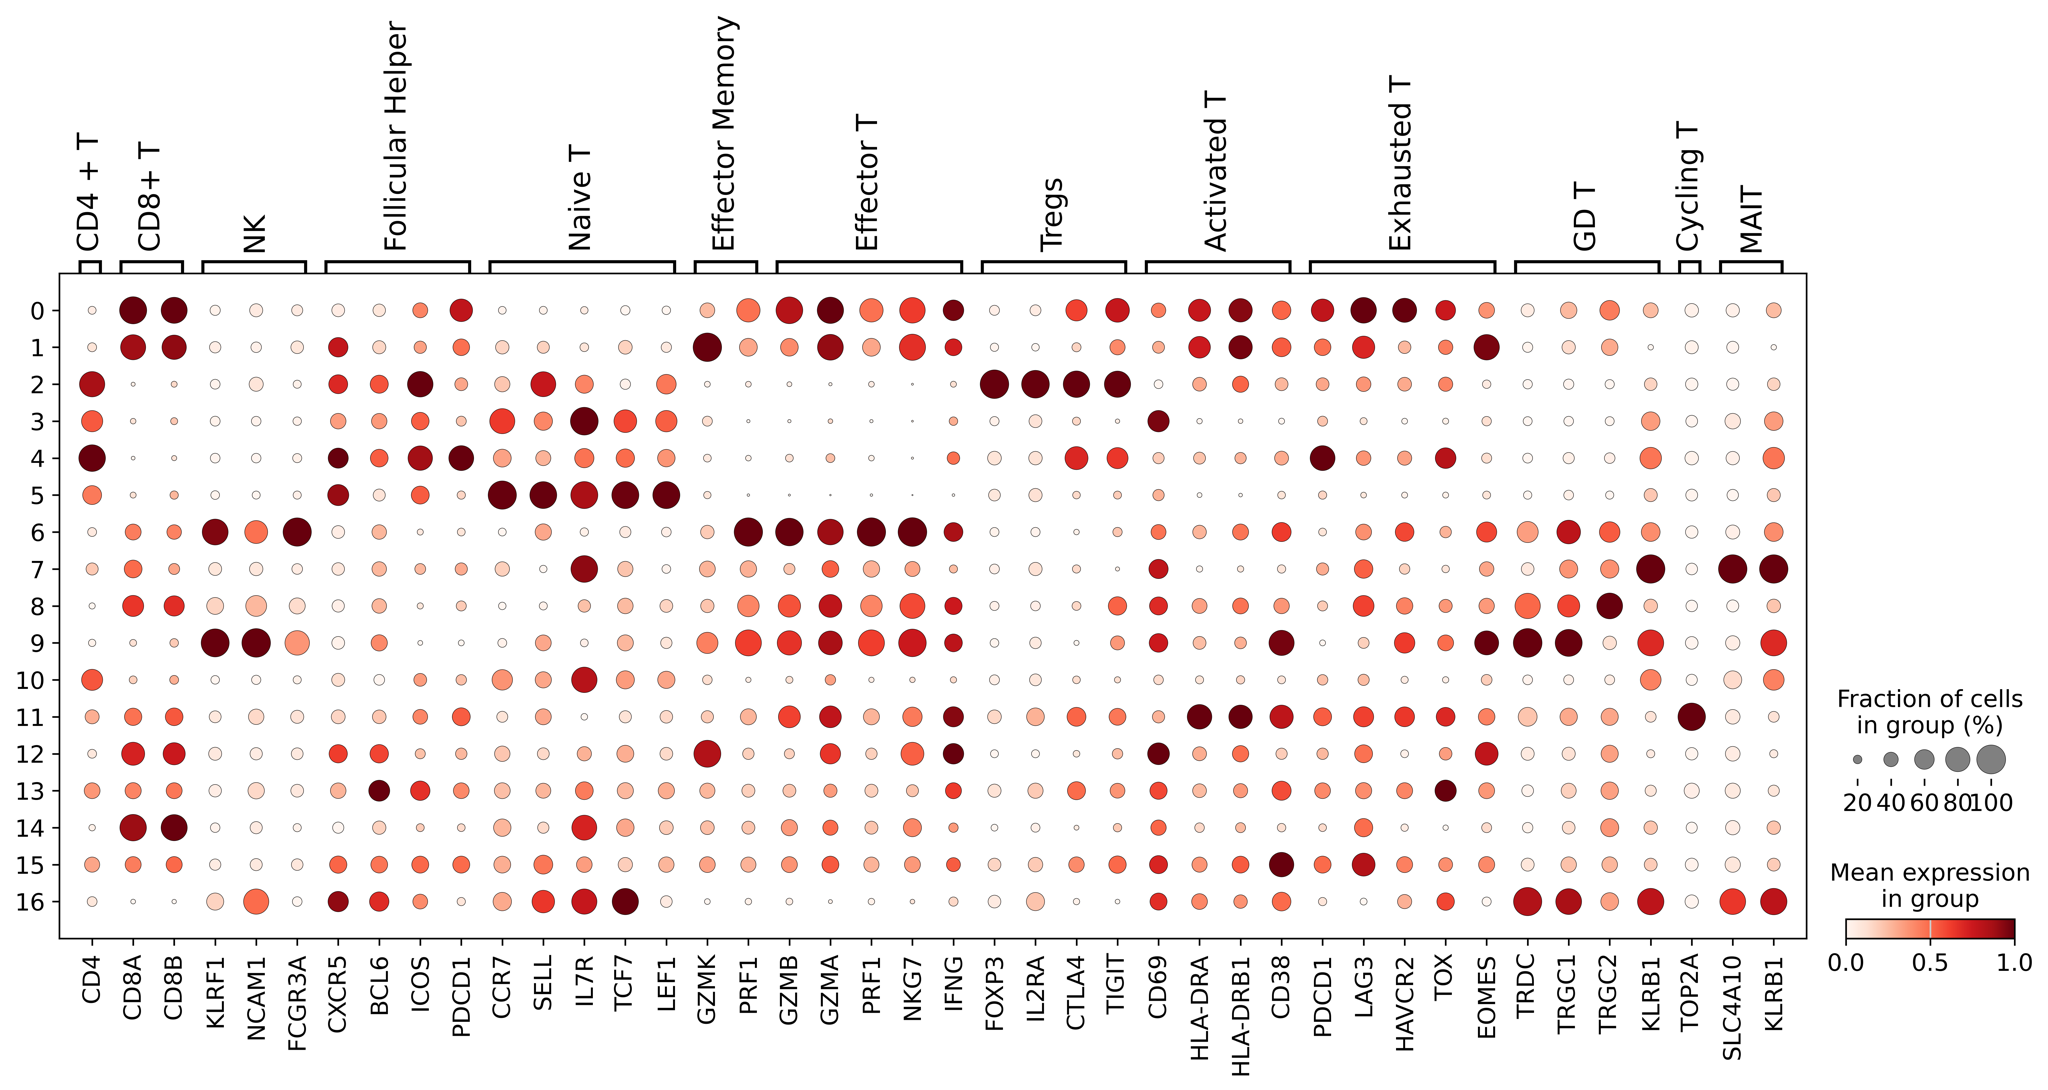

In [53]:

sc.settings.set_figure_params(dpi=300, dpi_save=300, figsize=(15,5), facecolor='white')

marker_dict = {
    'CD4 + T': ['CD4'],
    'CD8+ T': ['CD8A', 'CD8B'],
    'NK': ['KLRF1', 'NCAM1', 'FCGR3A'], #NCAM1 = CD56, FCGR3A = CD16
    'Follicular Helper': ['CXCR5', 'BCL6', 'ICOS', 'PDCD1'],
    'Naive T': ['CCR7', 'SELL',  'IL7R', 'TCF7', 'LEF1'],
    'Effector Memory': ['GZMK', 'PRF1'],
    'Effector T': [ 'GZMB', 'GZMA', 'PRF1', 'NKG7', 'IFNG'],
    'Tregs': ['FOXP3', 'IL2RA', 'CTLA4', 'TIGIT'],
    'Activated T' : ['CD69', 'HLA-DRA', 'HLA-DRB1', 'CD38'],
    'Exhausted T' : ['PDCD1', 'LAG3', 'HAVCR2', 'TOX', 'EOMES'],
    'GD T': ['TRDC', 'TRGC1', 'TRGC2', 'KLRB1'],
    'Cycling T': ['TOP2A'],
    'MAIT': ['SLC4A10', 'KLRB1']
}


sc.pl.dotplot(
    integrated, marker_dict, 'leiden',
    standard_scale='var', swap_axes=False
)

#sc.pl.dotplot(adata, marker_dict, groupby='leiden', figsize=(12,6), standard_scale='var',  dendrogram=True, save='markers.pdf')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


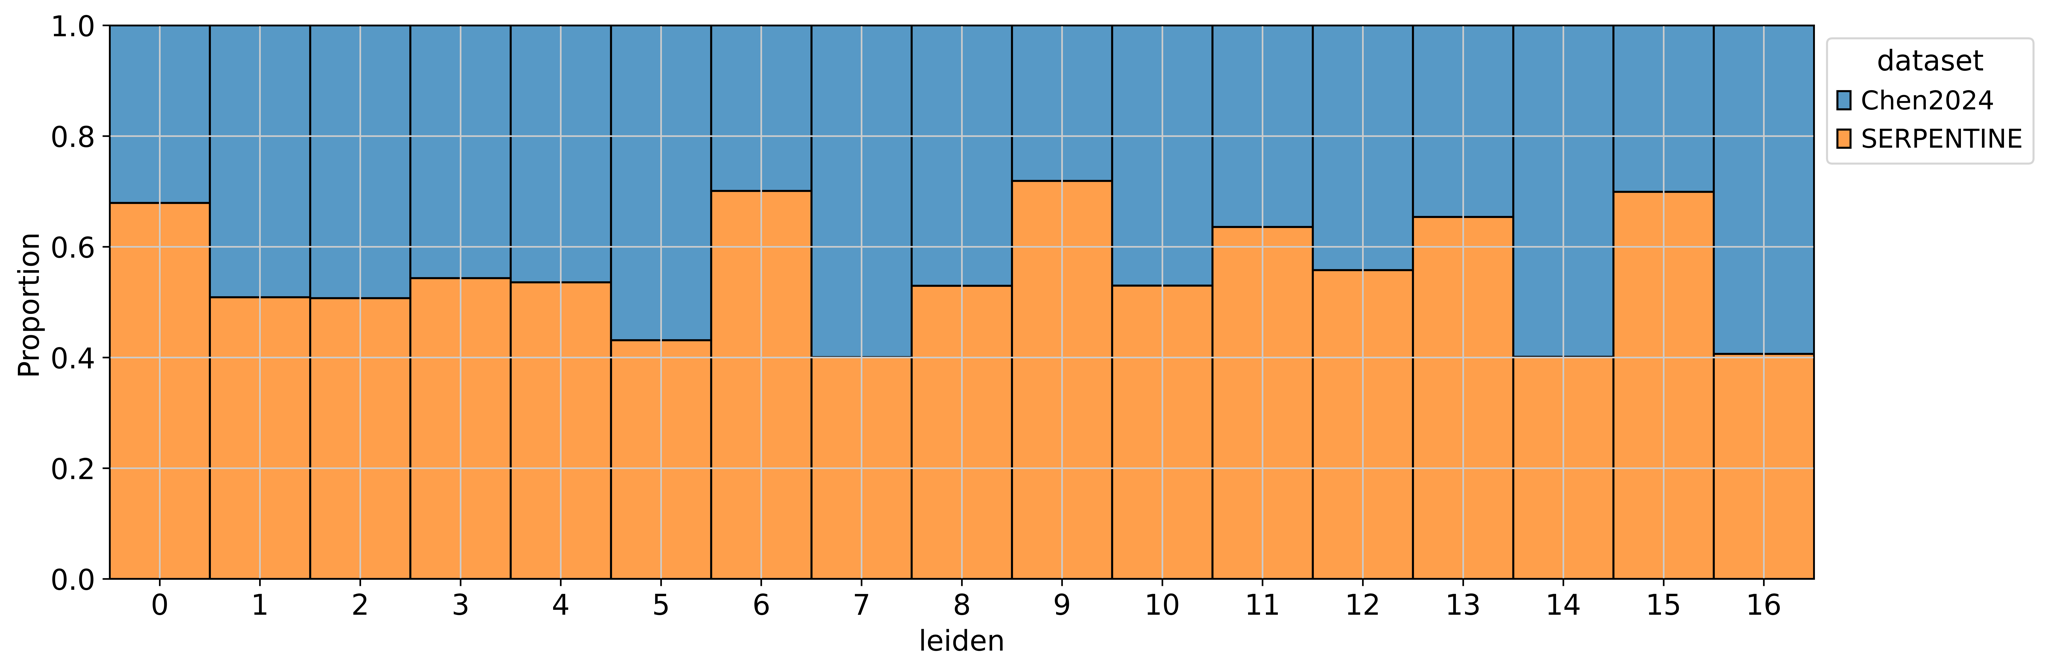

In [54]:
# stacked bar chart
sc.settings.set_figure_params(dpi=400, dpi_save=500, figsize=(15,5), facecolor='white')
ax = sns.histplot(
    data = integrated.obs,
    x = 'leiden',
    hue = 'dataset',
    multiple='fill', stat='proportion',
    discrete=True
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [56]:
integrated.obs.dataset.value_counts()

dataset
SERPENTINE    156759
Chen2024      123366
Name: count, dtype: int64

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

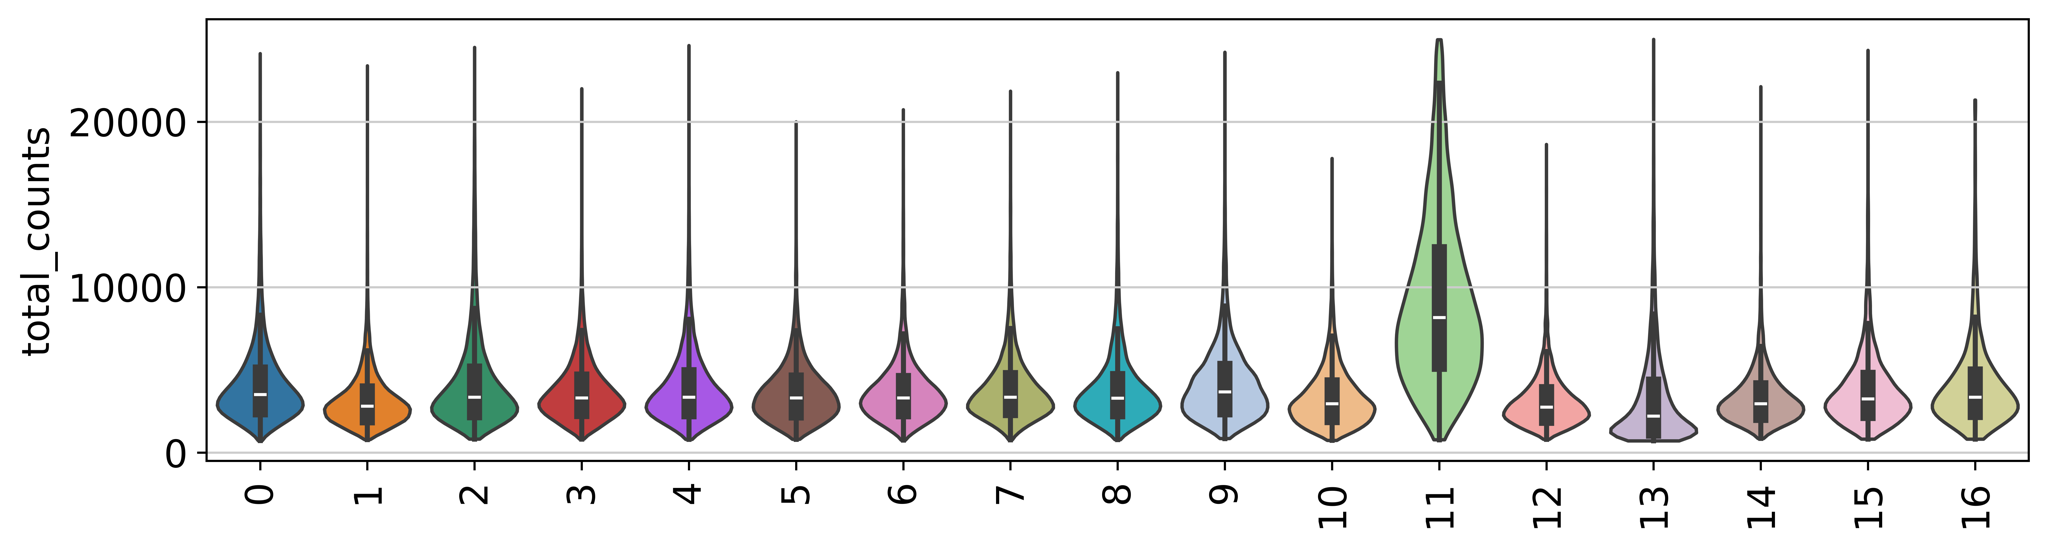

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

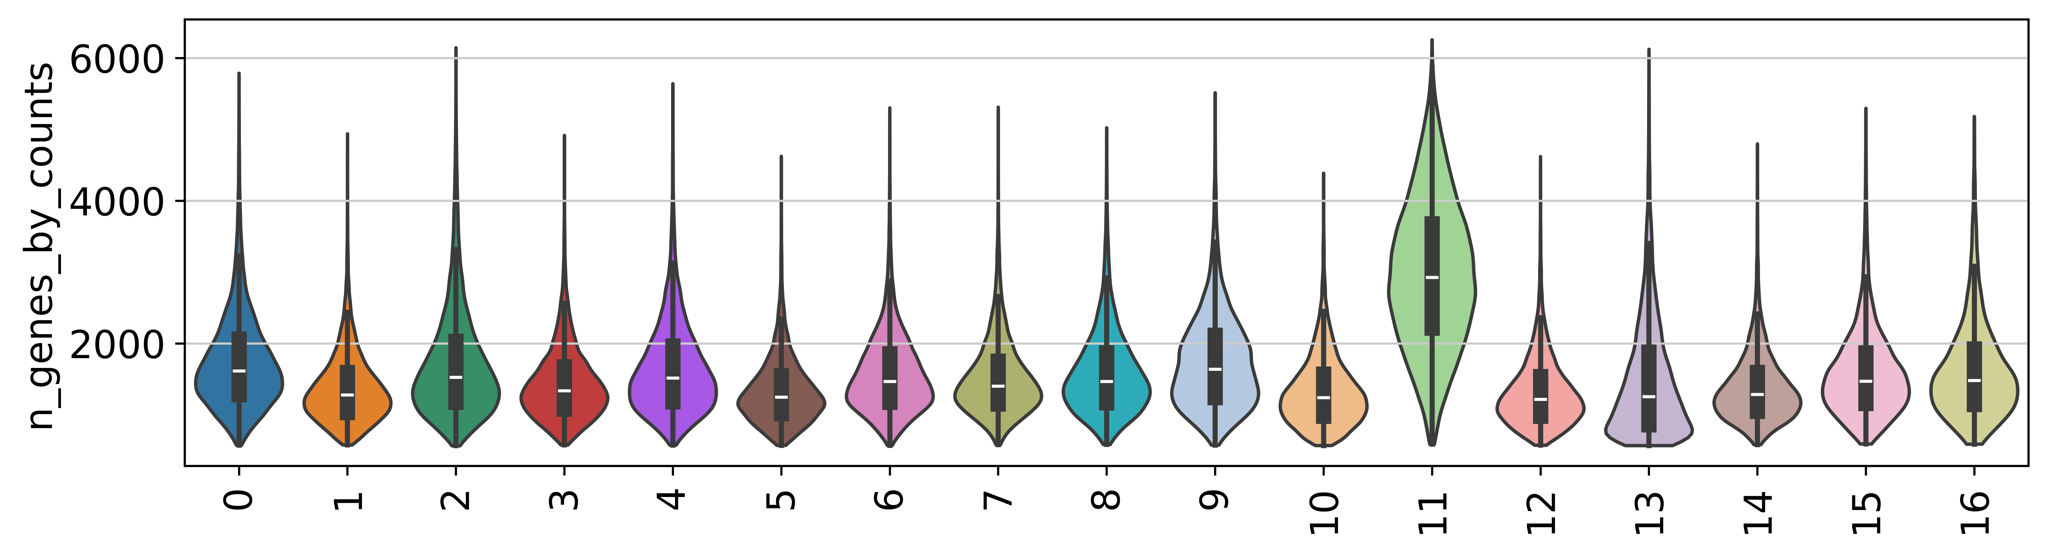

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

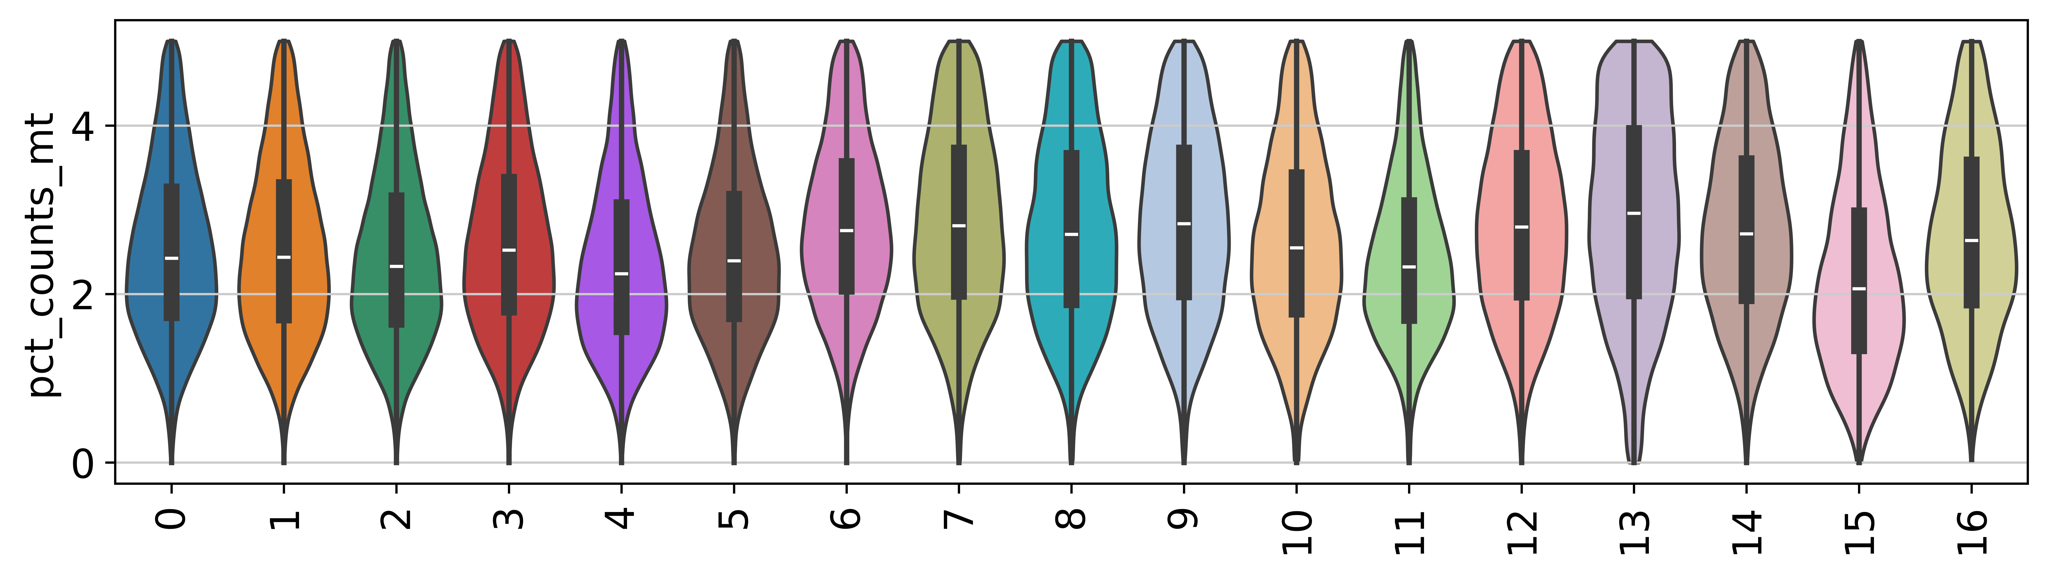

In [57]:
sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(10,3), facecolor='white')
sc.pl.violin(integrated,[ 'total_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(integrated,[ 'n_genes_by_counts'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)
sc.pl.violin(integrated,[ 'pct_counts_mt'], inner='box', size=0,  groupby='leiden', multi_panel=False, rotation=90)

## Evaluate performance of signal preservation

[Following this tutorial from CellANOVA.](https://github.com/Janezjz/cellanova/blob/main/tutorials/eval_signal_preservation.ipynb)


In [76]:
? cnova.utils.calc_oobNN

Signature:
 cnova.utils.calc_oobNN(
    adata_orig,
    batch_key,
    condition_key,
    n_neighbors=15,
)
Docstring:
Compute out-of-batch k-nearest-neighbor composition 

Parameters
----------
adata_orig : anndata object
    Expression data stored in adata_orig.X, based on which to compute out of batch nearest neighbors.
batch_key : str
    Variable name indicating batch. Should be a column name of adata.obs.
condition_key : str
    Variable name indicating condition. Should be a column name of adata.obs. 
    We compute out-of-batch proportion of each condition level within each cell's neighborhood.
n_neighbors : int, optional
    Number of k-nearest neighbors.

Returns
----------
res: anndata object
    One new attribute added. 
    res.obsm['knn_prop'] : pd.DataFrame, out-of-batch k-nearest-neighbor composition, cell-by-condition
File:      ~/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py
Type:      function


In [66]:
# no idea how long this will take to run
res = cnova.utils.calc_oobNN(
    integrated, 
    batch_key='Replicate', 
    condition_key='Timepoint'
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdou

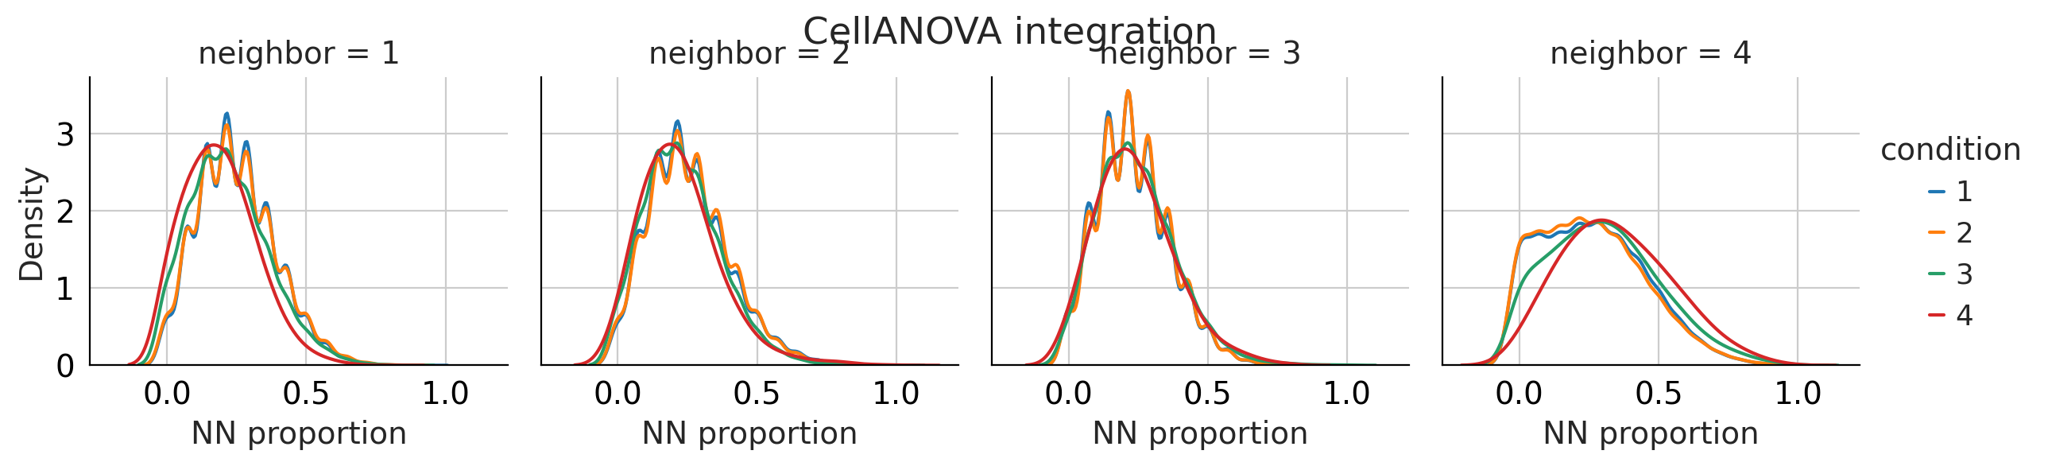

In [78]:
df = res.obsm['knn_prop']
df['condition'] = res.obs['Timepoint']
df = df.reset_index()
df = pd.melt(df, id_vars=['barcode', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'barcode': 'obs_name'})

g = sns.FacetGrid(df, col='neighbor', hue='condition')
g.map(sns.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('CellANOVA integration')
sns.set_style('white')
plt.show()

In [79]:
# no idea how long this will take to run
res = cnova.utils.calc_oobNN(
    integrated, 
    batch_key='Replicate', 
    condition_key='Tissue'
)


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdout.obsm['knn_prop'] = knn_df
/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/cellanova/utils.py:107: ImplicitModificationWarning: Setting element `.obsm['knn_prop']` of view, initializing view as actual.
  adata_holdou

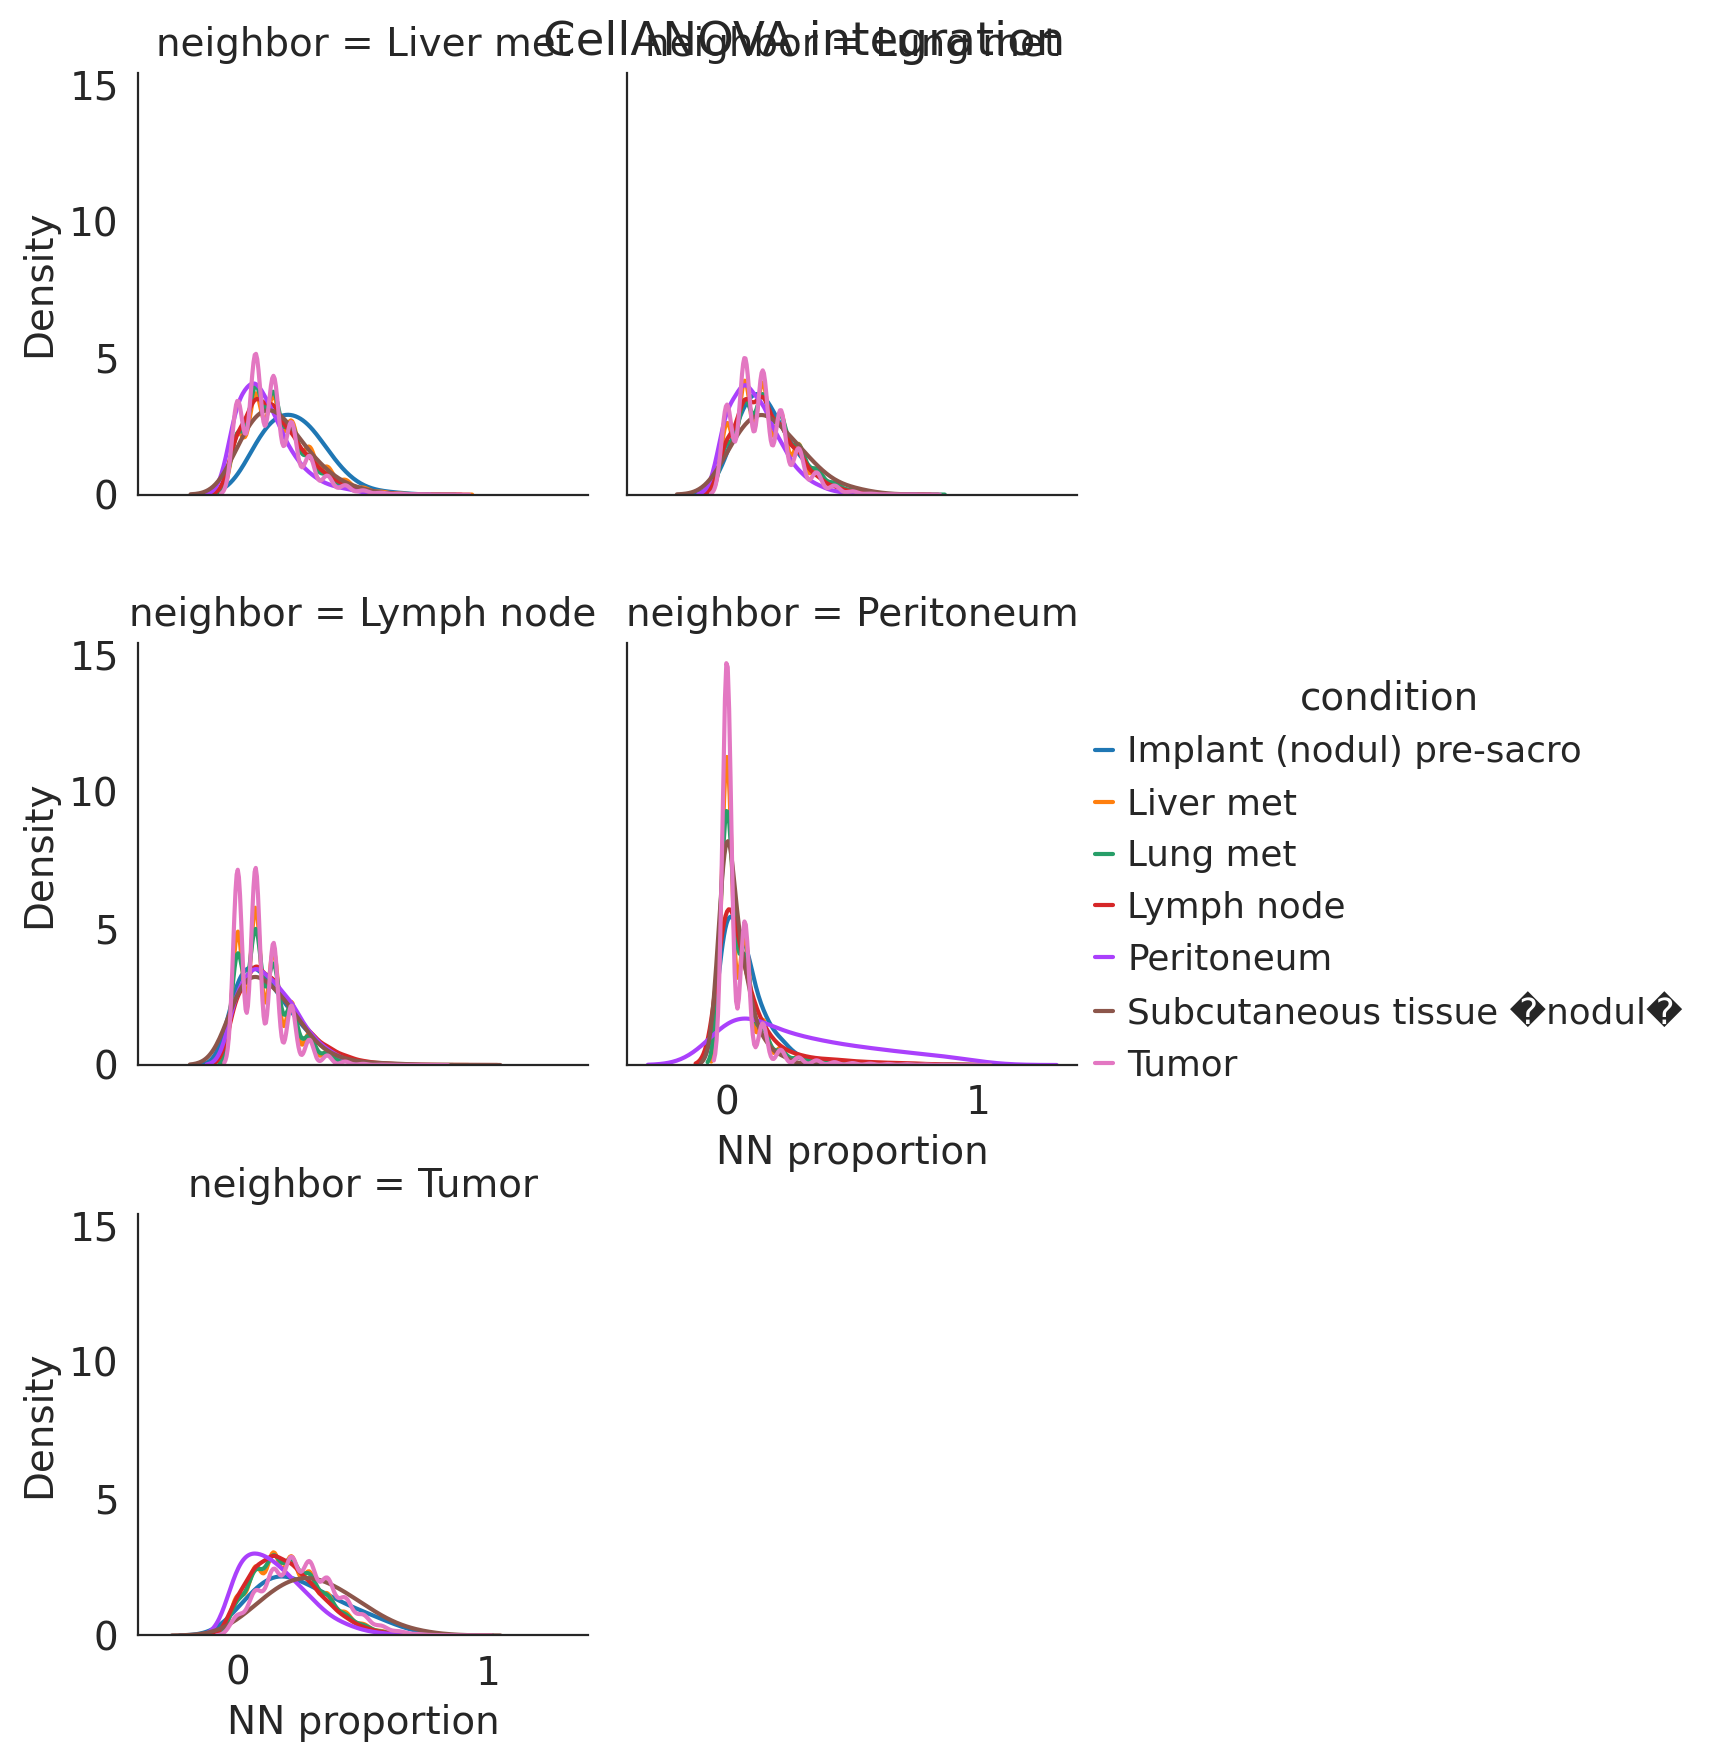

In [81]:
df = res.obsm['knn_prop']
df['condition'] = res.obs['Tissue']
df = df.reset_index()
df = pd.melt(df, id_vars=['barcode', 'condition'], var_name='neighbor', value_name='proportion')
df = df.rename(columns={'barcode': 'obs_name'})

g = sns.FacetGrid(df, col='neighbor', hue='condition', col_wrap=2)
g.map(sns.kdeplot, 'proportion', bw_adjust=2, alpha=1)
g.set(xlabel='NN proportion', ylabel='Density')
g.add_legend()
plt.suptitle('CellANOVA integration')
sns.set_style('white')
plt.show()

In [77]:
adata.shape

(280125, 1408)

## Marker genes

In [58]:
sc.tl.rank_genes_groups(integrated, groupby='leiden', method="wilcoxon")


In [60]:
group_key='leiden'

# get marker genes and add percent expressed
marker_genes_df = sc.get.rank_genes_groups_df(integrated, group=None)
markers = append_percent_expressed(adata, marker_genes_df, group_key, 0.5) 


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [63]:
markers.to_csv(
    "{}markers/integrated_{}_subcluster_{}_markers.csv".format(data_dir, cur_name, 'leiden1'),
    index=False
)


# set the thresholds for plotting
p_thresh = 0.05 
lfc_thresh = 1.0
pct_in_thresh = 10

# Subset for p-value, log fold change, and percentage expression thresholds
filtered_markers = markers[
    (markers["pvals_adj"] <= p_thresh) &
    (markers["logfoldchanges"] >= lfc_thresh) &
    (markers["pct_in_group"] >= pct_in_thresh)
]

filtered_markers.to_csv(
    "{}markers/integrated_{}_subcluster_{}_markers_signif.csv".format(data_dir, cur_name, 'leiden1'),
    index=False
)



/scratch_tmp/33192744/ipykernel_215404/2652725387.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_markers


/home/groups/singlecell/smorabito/.conda/envs/scanpy-081124/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


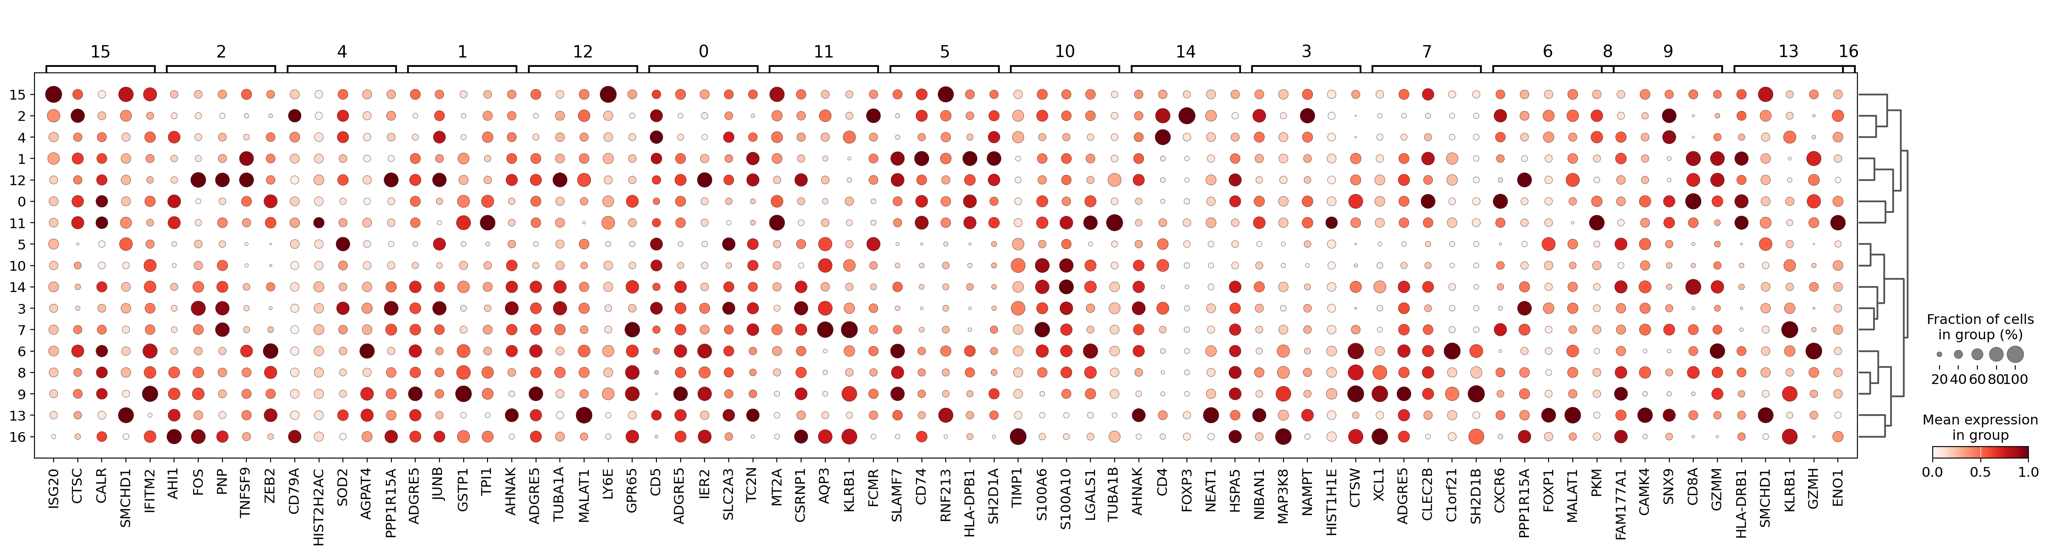

In [65]:
sc.settings.set_figure_params(dpi=100, dpi_save=500, figsize=(5,3), facecolor='white')

#-----------------------------------------------------------#
# make dotplots of the top 5 marker genes per cluster
#-----------------------------------------------------------#

cur_cluster = 'leiden_1'

# set the thresholds for plotting
p_thresh = 0.05 
lfc_thresh = 1.0
pct_in_thresh = 25
top_n = 5

# get the full list of marker genes
markers = pd.read_csv(
    "{}markers/integrated_{}_subcluster_{}_markers.csv".format(data_dir, cur_name, 'leiden1')
)
markers.group = markers.group.astype(str).astype('category')
markers.group = markers.group.cat.reorder_categories(integrated.obs[cur_cluster].cat.categories.to_list(), ordered=True)

# Subset for p-value, log fold change, and percentage expression thresholds
filtered_markers = markers[
    (markers["pvals_adj"] < p_thresh) &
    (markers["logfoldchanges"] > lfc_thresh) &
    (markers["pct_in_group"] > pct_in_thresh)
]

# Get the top N markers per group
top_markers = (
    filtered_markers
    .groupby("group")
    .apply(lambda x: x.sort_values(by="logfoldchanges", ascending=False).head(top_n))
)
top_markers = top_markers.reset_index(drop=True)

# calculate marker genes for each of these clusters
features = top_markers.groupby("group")["names"].apply(list).to_dict()

sc.pl.dotplot(
    integrated, features, 'leiden',
    standard_scale='var', swap_axes=False,
    dendrogram=True,
    save = '{}_integrated_subcluster_leiden_top5markers.pdf'.format(cur_name)
)


## Save the results

In [83]:
# save the results
integrated.write('{}{}_CellANOVA_16-12-24_processed.h5ad'.format(data_dir, cur_name))

In [84]:
# save the results
adata.write('{}{}_CellANOVA_16-12-24_processed_full.h5ad'.format(data_dir, cur_name))

In [47]:
adata.obs[adata.obs.dataset == 'SERPENTINE'].orig_annotation.value_counts()

orig_annotation
CD8+ Trm Exhausted        7164
CD8+ T Effector Memory    5755
CD4+ T Central Memory     5728
CD8+ T Effector           5663
CD56bright CD16hi NK      3829
                          ... 
c15_CD8_Tn_CCR7              0
c16_CD8_Tn_SELL              0
c17_CD8_Tcm_GPR183           0
c18_CD8_Tcm_ANXA1            0
c05_CD4_Tcm_GPR183           0
Name: count, Length: 70, dtype: int64